In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
## Define model

# Import the DPTForSemanticSegmentation from the Transformers library
from transformers import DPTForSemanticSegmentation

# Create the DPTForSemanticSegmentation model and load the pre-trained weights
# The "Intel/dpt-large-ade" model is a large-scale model trained on the ADE20K dataset
model = DPTForSemanticSegmentation.from_pretrained("Intel/dpt-large-ade")

config.json:   0%|          | 0.00/6.91k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DPTForSemanticSegmentation were not initialized from the model checkpoint at Intel/dpt-large-ade and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.batch_norm2.running_mean', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.running_var', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.running_var', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.bias', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.running_mean', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.

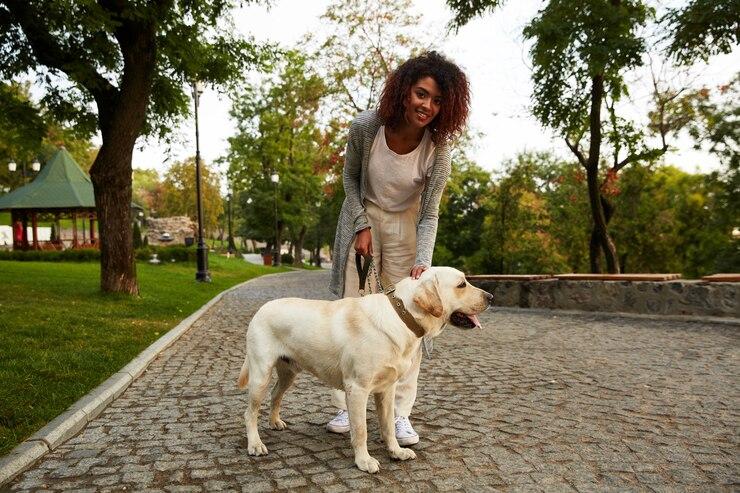

In [ ]:
# Import the Image class from the PIL (Python Imaging Library) module
from PIL import Image

import requests

# URL of the image to be downloaded
url = 'https://img.freepik.com/free-photo/happy-lady-hugging-her-white-friendly-dog-while-walking-park_171337-19281.jpg?w=740&t=st=1689214254~exp=1689214854~hmac=a8de6eb251268aec16ed61da3f0ffb02a6137935a571a4a0eabfc959536b03dd'

# The `stream=True` parameter ensures that the response is not immediately downloaded, but is kept in memory
response = requests.get(url, stream=True)

# Create the Image class
image = Image.open(response.raw)

# Display image
image

In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Set the desired height and width for the input image
net_h = net_w = 480

# Define a series of image transformations
transform = Compose([
        # Resize the image
        Resize((net_h, net_w)),
        # Convert the image to a PyTorch tensor
        ToTensor(),
        # Normalize the image
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

In [ ]:
# Transform input image
pixel_values = transform(image)

pixel_values = pixel_values.unsqueeze(0)

In [ ]:
import torch

# Disable gradient computation
with torch.no_grad():
    # Perform a forward pass through the model
    outputs = model(pixel_values)
    # Obtain the logits (raw predictions) from the output
    logits = outputs.logits

In [ ]:
import torch

# Interpolate the logits to the original image size
prediction = torch.nn.functional.interpolate(
    logits,
    size=image.size[::-1],  # Reverse the size of the original image (width, height)
    mode="bicubic",
    align_corners=False
)

# Convert logits to class predictions
prediction = torch.argmax(prediction, dim=1) + 1

# Squeeze the prediction tensor to remove dimensions
prediction = prediction.squeeze()

# Move the prediction tensor to the CPU and convert it to a numpy array
prediction = prediction.cpu().numpy()

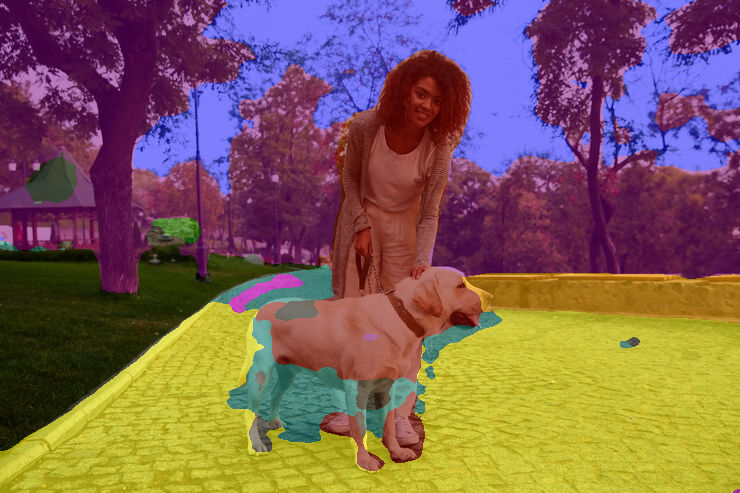

In [ ]:
from PIL import Image

# Convert the prediction array to an image
predicted_seg = Image.fromarray(prediction.squeeze().astype('uint8'))

adepallete = [
    255, 0, 0,     # Red
    255, 165, 0,   # Orange
    0, 128, 0,     # Green
    0, 0, 255,     # Blue
    255, 255, 0,   # Yellow
    128, 0, 128,   # Purple
    0, 255, 255,   # Cyan
    255, 0, 255,   # Magenta
    128, 128, 128, # Gray
    255, 255, 255, # White
    0, 0, 0,       # Black
    128, 64, 0,    # Brown
    192, 192, 192, # Silver
    128, 0, 0,     # Maroon
    0, 128, 128    # Teal
]

# Now you can use predicted_seg.putpalette(adepallete)
predicted_seg.putpalette(adepallete)

# Apply the color map to the predicted segmentation image
predicted_seg.putpalette(adepallete)

# Blend the original image and the predicted segmentation image
out = Image.blend(image, predicted_seg.convert("RGB"), alpha=0.5)
out